# Лабораторная работа 4. Кластеризация
## 1. Введение
**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Постановка задачи:**
1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.
## 2. Описание датасета
Датасет **Wine Dataset for Clustering** представляет собой классический набор данных, изначально полученный из задачи классификации, но часто используемый и для задач кластеризации. Он содержит результаты химического анализа вин, произведенных в конкретном регионе Италии. Каждое вино характеризуется 13 различными химическими признаками. В оригинальной задаче классификации вина принадлежат к одному из 3 сортов.

**Структура датасета:**

- Количество наблюдений: 178
- Количество признаков: 13

**Описание признаков:**

- Alcohol - процент содержания алкоголя.
- Malic acid - содержание яблочной кислоты.
- Ash - содержание золы.
- Alcanity of ash - щелочность золы.
- Magnesium - содержание магния.
- Total phenols - общее содержание фенолов.
- Flavanoids - содержание флавоноидов.
- Nonflavanoid phenols - содержание нефлавоноидных фенолов.
- Proanthocyanins - содержание проантоцианидинов.
- Color intensity - интенсивность цвета.
- Hue - цветовой оттенок.
- OD280/OD315 of diluted wines - результаты спектроскопии (отношение оптической плотности при 280 и 315 нм).
- Proline - содержание аминокислоты пролин.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from itertools import combinations
from sklearn.metrics import (
    adjusted_rand_score,
    rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    fowlkes_mallows_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    silhouette_score,
    calinski_harabasz_score
)

In [18]:
df_full = pd.read_csv('Wine dataset.csv')

y_true = df_full.iloc[:, 0]
X = df_full.iloc[:, 1:]

print("Размерность датасета:", X.shape)

print("\nТипы данных:")
print(X.dtypes)
print("\nПропущенные значения:")
print(X.isnull().sum().sum())
print("\nПервые строки датасета:")
X.head()

Размерность датасета: (178, 13)

Типы данных:
Alcohol                         float64
Malic acid                      float64
Ash                             float64
Alcalinity of ash               float64
Magnesium                         int64
Total phenols                   float64
Flavanoids                      float64
Nonflavanoid phenols            float64
Proanthocyanins                 float64
Color intensity                 float64
Hue                             float64
OD280/OD315 of diluted wines    float64
Proline                           int64
dtype: object

Пропущенные значения:
0

Первые строки датасета:


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


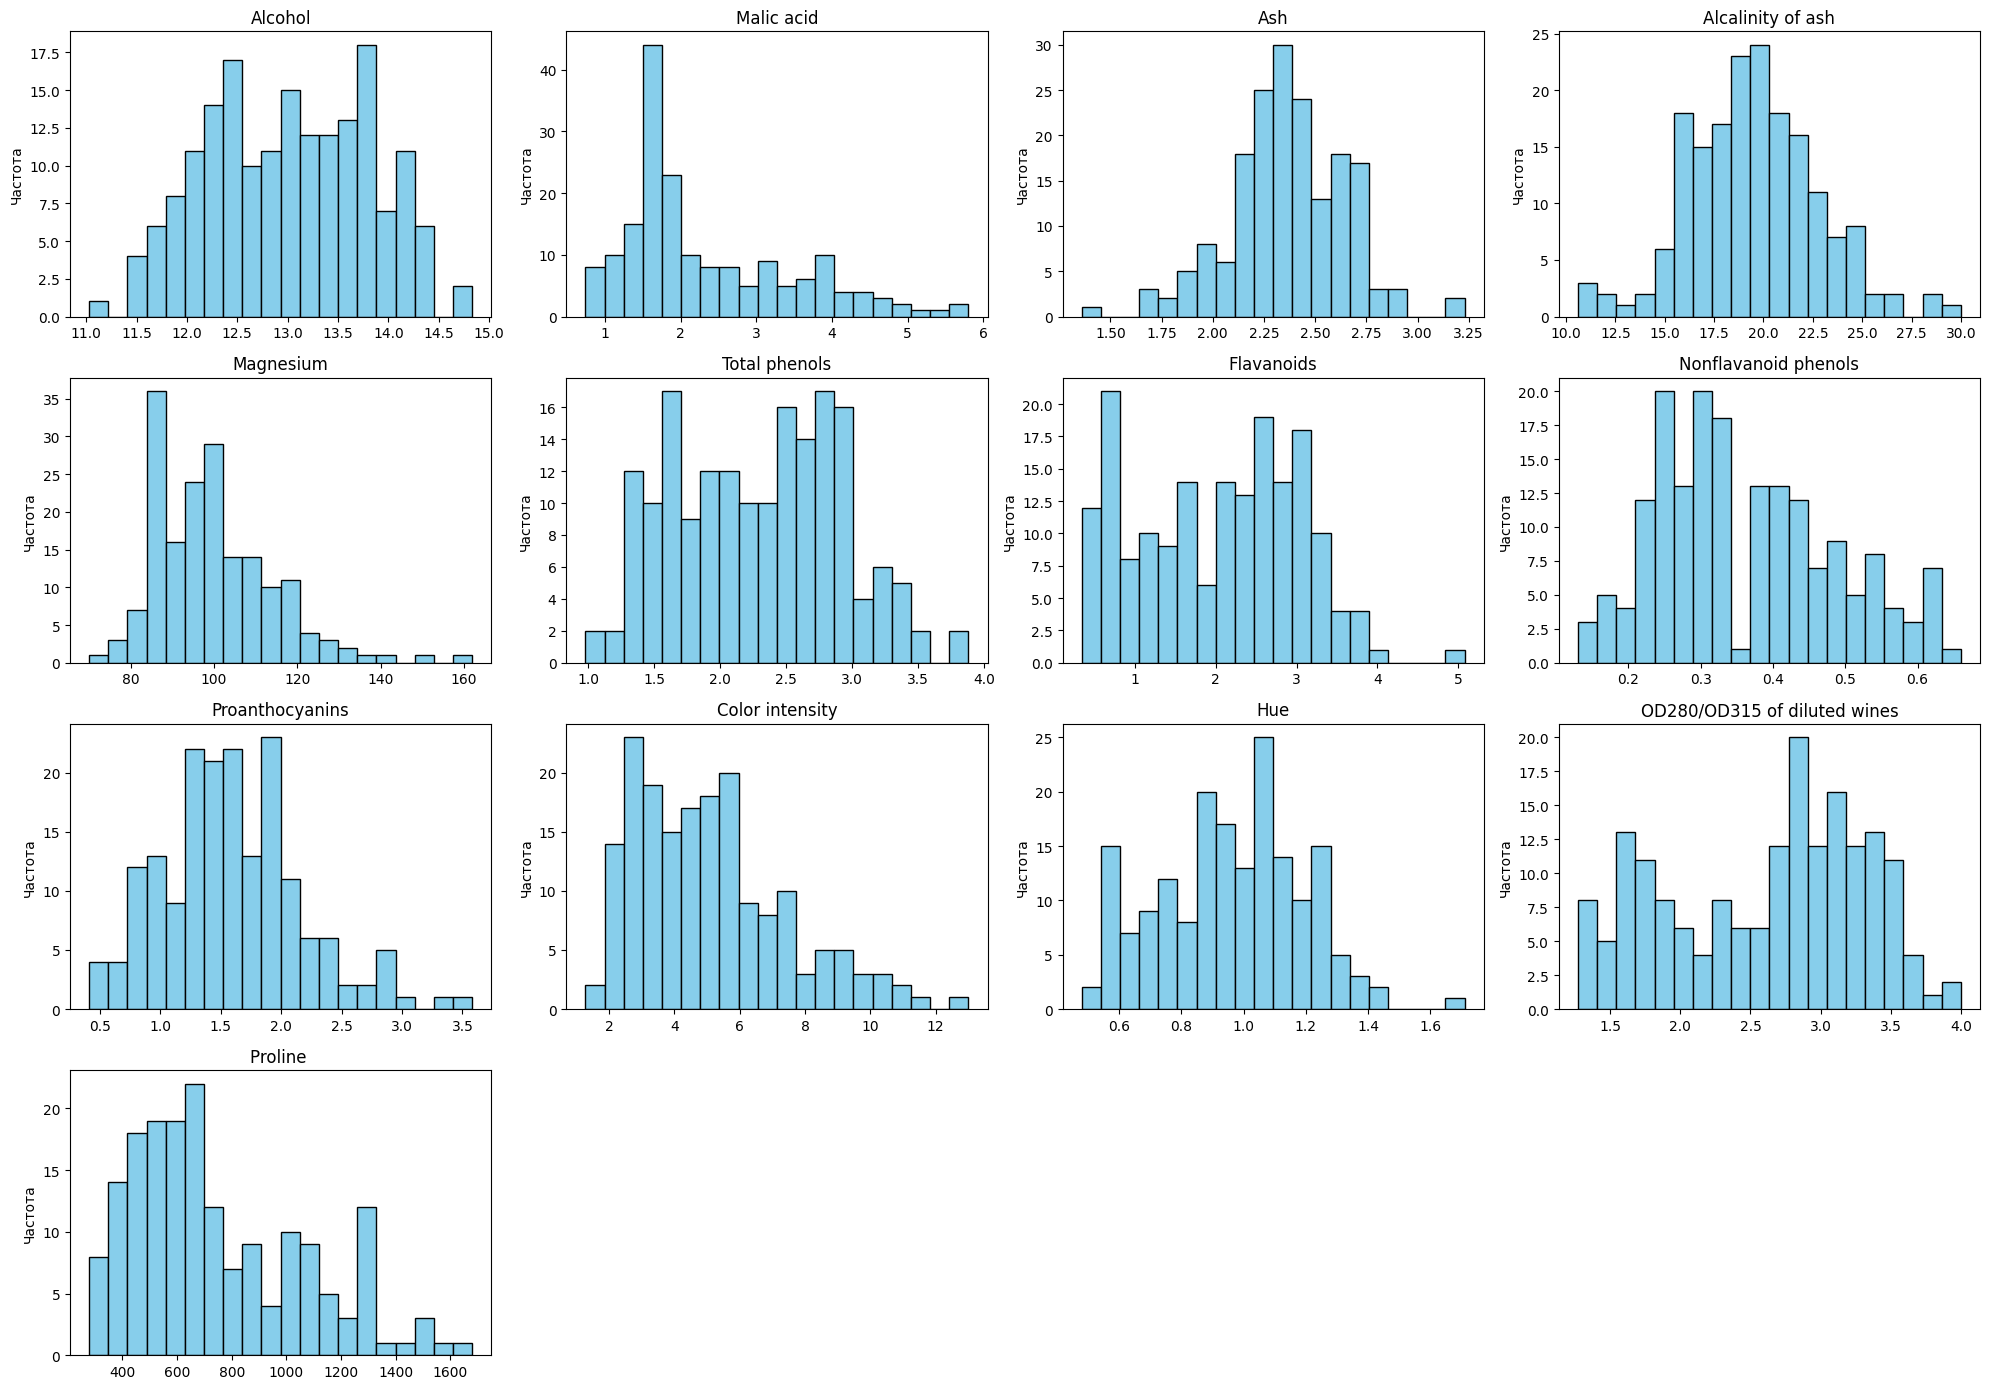

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(20, 14))
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].hist(X[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_ylabel('Частота')

for i in range(len(X.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [20]:
stats = pd.DataFrame({
    'Среднее': X.mean(),
    'Медиана': X.median(),
    'Мода': X.mode().iloc[0] if not X.mode().empty else np.nan,
    'Минимум': X.min(),
    'Максимум': X.max(),
    'Асимметрия': X.skew(),
    'Эксцесс': X.kurtosis()
})

stats = stats.round(4)
stats

,Среднее,Медиана,Мода,Минимум,Максимум,Асимметрия,Эксцесс
Alcohol,13.0006,13.050,12.37,11.03,14.83,-0.0515,-0.8525
Malic acid,2.3363,1.865,1.73,0.74,5.80,1.0397,0.2992
Ash,2.3665,2.360,2.28,1.36,3.23,-0.1767,1.1440
Alcalinity of ash,19.4949,19.500,20.00,10.60,30.00,0.2130,0.4879
Magnesium,99.7416,98.000,88.00,70.00,162.00,1.0982,2.1050
Total phenols,2.2951,2.355,2.20,0.98,3.88,0.0866,-0.8356
Flavanoids,2.0293,2.135,2.65,0.34,5.08,0.0253,-0.8804
Nonflavanoid phenols,0.3619,0.340,0.26,0.13,0.66,0.4502,-0.6372
Proanthocyanins,1.5909,1.555,1.35,0.41,3.58,0.5171,0.5546
Color intensity,5.0581,4.690,2.60,1.28,13.00,0.8686,0.3815


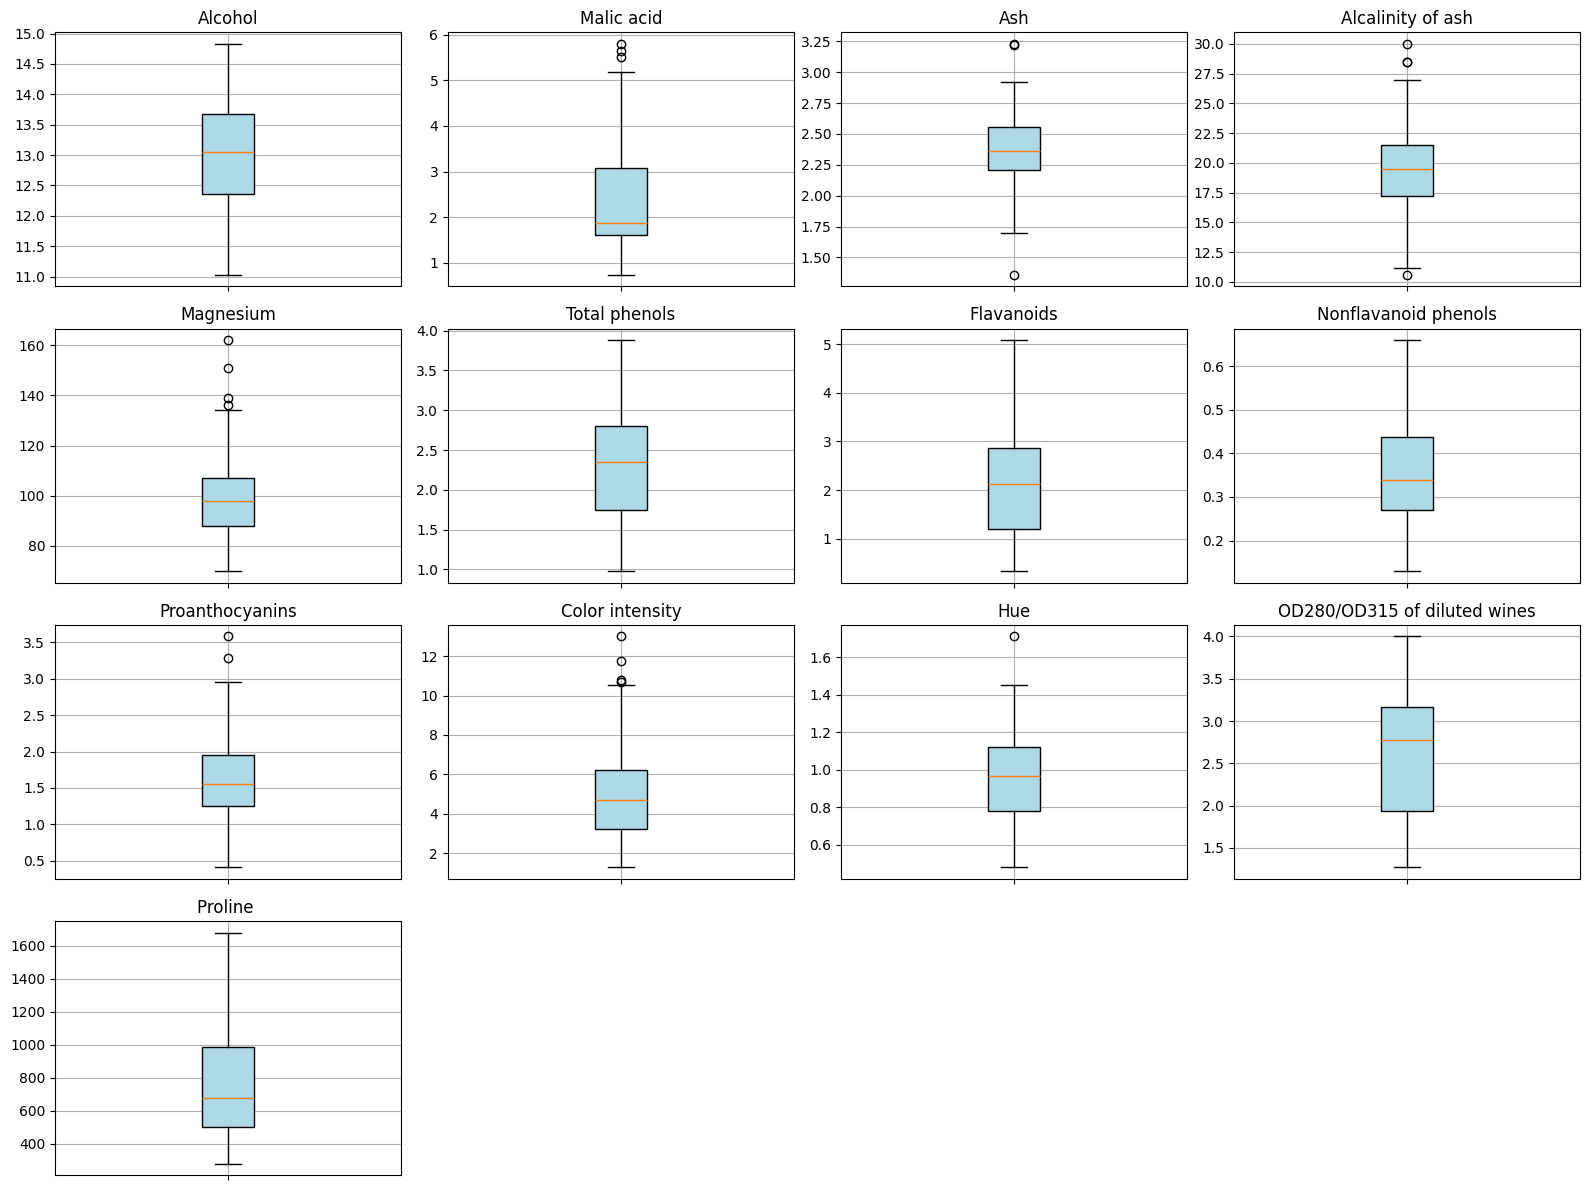

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    axes[i].boxplot(X[col], patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axes[i].set_title(col)
    axes[i].set_ylabel('')
    axes[i].grid(True)
    axes[i].set_xticklabels([])

for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

1. Alcohol - содержание алкоголя в винах распределено почти симметрично вокруг среднего значения 13.00, медиана (13.05) близка к среднему, асимметрия незначительна, что указывает на нормальность распределения; минимальное значение 11.03, максимальное — 14.83, выбросы отсутствуют.

2. Malic acid - уровень яблочной кислоты имеет выраженную правостороннюю асимметрию (1.04), что означает наличие редких образцов с высоким содержанием кислоты, медиана (1.87) значительно ниже среднего (2.34), подтверждая скос, максимальное значение 5.80 является потенциальным выбросом.

3. Ash - содержание золы распределено практически симметрично (асимметрия -0.18), медиана и среднее почти совпадают, эксцесс 1.14 указывает на более острую вершину, чем у нормального распределения, диапазон значений узкий — от 1.36 до 3.23.

4. Alcanity of ash - щелочность золы имеет слабую правостороннюю асимметрию (0.21) и умеренный эксцесс (0.49), распределение близко к нормальному, медиана и среднее совпадают, выбросы присутствуют, но не критичны для анализа.

5. Magnesium - содержание магния сильно скошено вправо (асимметрия 1.10), медиана (98.0) почти совпадает со среднеим (99.74), что говорит о наличии образцов с очень высоким содержанием, эксцесс 2.11 указывает на тяжелые хвосты и острую вершину, есть выбросы.

6. Total phenols - общее содержание фенолов почти симметрично распределено (асимметрия 0.09), эксцесс отрицательный (-0.84), что свидетельствует о плоской вершине, медиана (2.36) близка к среднему, выбросы минимальны.

7. Flavanoids - флаваноиды имеют почти симметричное распределение (асимметрия 0.03), с заметно отрицательным эксцессом (-0.88), что указывает на «плоское» распределение, медиана и среднее практически равны, выбросов нет.

8. Nonflavanoid phenols - нефлаваноидные фенолы имеют умеренную правостороннюю асимметрию (0.45), медиана (0.34) ниже среднего (0.36), распределение слегка скошено, но без резких выбросов, эксцесс отрицательный (-0.64), что указывает на плоскую вершину.

9. Proanthocyanins - содержание проантоцианидинов имеет умеренную правостороннюю асимметрию (0.52) и положительный эксцесс (0.55), что говорит о наличии пиков и длинных хвостов, медиана (1.56) почти совпадает со средним (1.59), выбросы есть.

10. Color intensity - интенсивность цвета сильно скошена вправо (асимметрия 0.87), медиана (4.69) ниже среднего (5.06), что указывает на наличие образцов с очень насыщенным цветом, эксцесс 0.38 указывает на острую вершину, выбросы присутствуют.

11. Hue - оттенок имеет почти симметричное распределение (асимметрия 0.02), эксцесс отрицательный (-0.34), что говорит о «плоском» распределении, медиана и среднее совпадают, выбросы присутствуют.

12. OD280/OD315 of diluted wines - оптическая плотность при 280 нм имеет левостороннюю асимметрию (-0.31) и отрицательный эксцесс (-1.09), что указывает на плоское распределение с легким смещением влево; медиана (2.78) выше среднего (2.61), выбросов нет.

13. Proline - содержание пролина сильно скошено вправо (асимметрия 0.77), медиана (673.5) значительно ниже среднего (746.9), что указывает на наличие редких образцов с очень высоким содержанием; эксцесс отрицательный (-0.25), что говорит о «плоской» вершине; выбросы нет.

## 3. Предобработка данных
Для предобработки данных был выбран **метод стандартизации** с использованием StandardScaler из библиотеки scikit-learn. Признаки в датасете имеют существенно разный масштаб - например, значения Proline измеряются в сотнях, в то время как Nonflavanoid_Phenols лежит в диапазоне единиц. Без масштабирования признаки с большими значениями будут неоправданно доминировать при вычислении расстояний, что исказит результаты кластеризации. Также в данных присутствуют выбросы, особенно в таких признаках, как Proanthocyanins, Magnesium и Color_Intensity. Стандартизация более устойчива к выбросам по сравнению с нормализацией, так как основана на среднем и стандартном отклонении, а не на крайних значениях.

<Figure size 1400x1200 with 0 Axes>

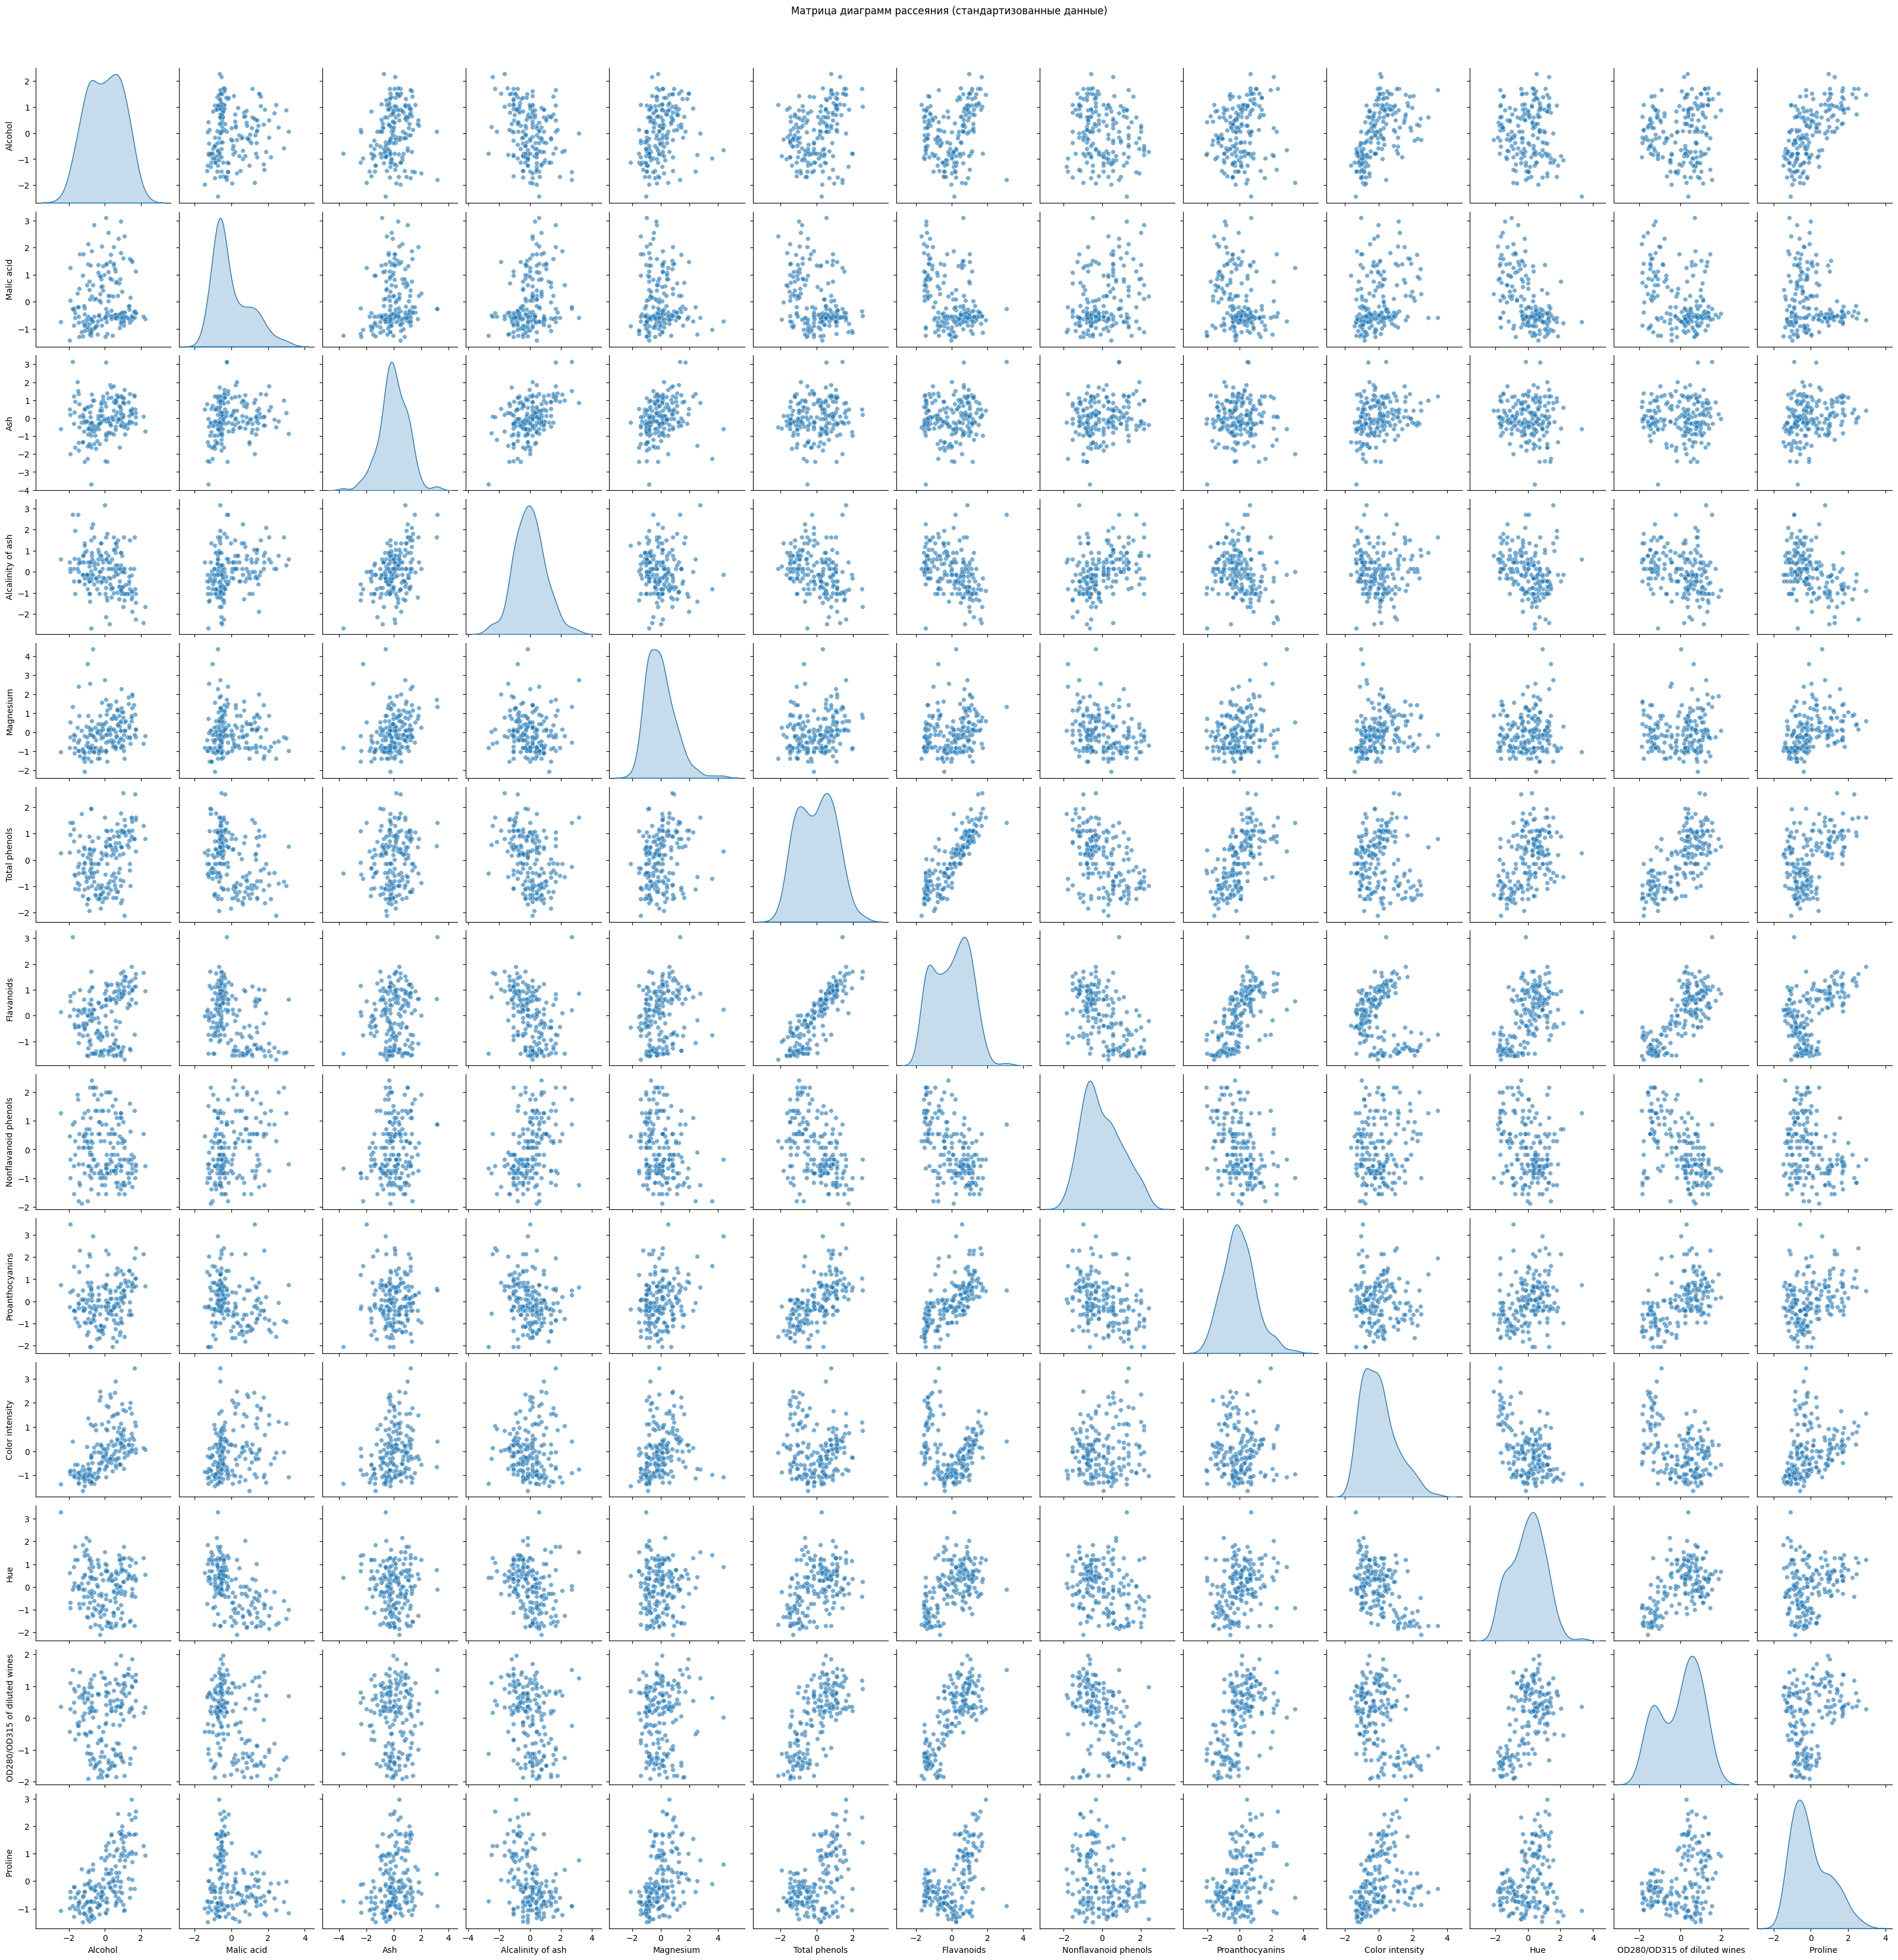

In [22]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(df_scaled, columns=X.columns)

plt.figure(figsize=(14, 12))
sns.pairplot(df_scaled, diag_kind='kde', plot_kws={'s': 30, 'alpha': 0.6})
plt.suptitle('Матрица диаграмм рассеяния (стандартизованные данные)', y=1.02)
plt.show()

Почти все пары признаков дают однородные облака, без чётких разрывов или групп. Некоторые пары признаков дают вытянутые облака (линейная корреляция), что соответствует гауссовым/эллиптическим кластерам, но границ не видно. Тип кластерной структуры - выпуклый (компактный, сферический). Использовать будем Gaussian Mixture Models (GMM), так как он умеет находить пересекающиеся и эллиптические кластеры, работает с слабо разделёнными структурами, и K-Means. Предполагается 2-3 кластера.

## 4. Ход работы
### a. K-mean

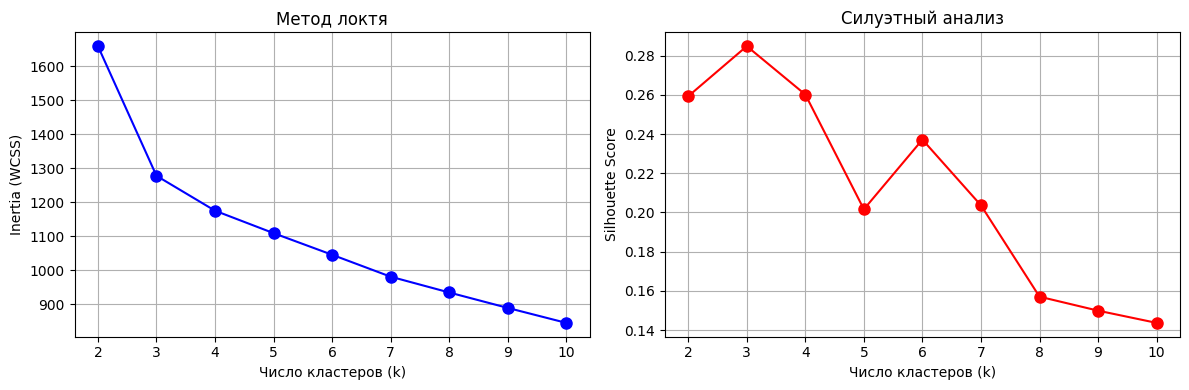

In [23]:
k_range = range(2, 11)
inertias_kmean = []
silhouette_scores_kmean = []
calinski_harabasz_scores_kmean = []
davies_bouldin_scores_kmean = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    
    inertias_kmean.append(kmeans.inertia_)
    silhouette_scores_kmean.append(silhouette_score(df_scaled, labels))
    calinski_harabasz_scores_kmean.append(calinski_harabasz_score(df_scaled, labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias_kmean, 'bo-', markersize=8)
plt.xlabel('Число кластеров (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Метод локтя')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores_kmean, 'ro-', markersize=8)
plt.xlabel('Число кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Силуэтный анализ')
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
metrics_df = pd.DataFrame({
    'k': k_range,
    'Inertia': inertias_kmean,
    'Silhouette': silhouette_scores_kmean,
    'Calinski-Harabasz': calinski_harabasz_scores_kmean,
})
metrics_df.round(3)

,k,Inertia,Silhouette,Calinski-Harabasz
0,2,1658.759,0.259,69.523
1,3,1277.928,0.285,70.940
2,4,1175.428,0.260,56.181
3,5,1109.513,0.202,46.952
4,6,1046.002,0.237,41.701
5,7,981.595,0.204,38.686
6,8,935.201,0.157,35.805
7,9,889.893,0.150,33.807
8,10,845.895,0.144,32.397


Излом на графике метода локтя наблюдается при k=3: дальнейшее увеличение числа кластеров приводит к лишь незначительному снижению внутрикластерной суммы квадратов (inertia). При k=3 достигается баланс между компактностью кластеров и общей интерпретируемостью разбиения. Максимальное значение силуэтного коэффициента также достигается при k=3, что указывает на оптимальную степень разделённости кластеров. Таким образом, оптимальное число кластеров: k=3.

In [25]:
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(df_scaled)

centers_scaled = kmeans_final.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)
print("Центры кластеров (в исходных единицах измерения):")
centers_df = pd.DataFrame(centers_original, columns=X.columns)
centers_df.index.name = 'Кластер'
centers_df.round(2)

Центры кластеров (в исходных единицах измерения):


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Кластер,,,,,,,,,,,,,
0,12.25,1.90,2.23,20.06,92.74,2.25,2.05,0.36,1.62,2.97,1.06,2.80,510.17
1,13.13,3.31,2.42,21.24,98.67,1.68,0.82,0.45,1.15,7.23,0.69,1.70,619.06
2,13.68,2.00,2.47,17.46,107.97,2.85,3.00,0.29,1.92,5.45,1.07,3.16,1100.23


In [26]:
distances_to_own_center = np.linalg.norm(
    df_scaled.values - centers_scaled[labels_kmeans], axis=1
)

intra_distances = {}
for i in range(3):
    mask = (labels_kmeans == i)
    intra_distances[i] = distances_to_own_center[mask]

print("\nВнутрикластерные расстояния:")
for i in range(3):
    d = intra_distances[i]
    print(f"Кластер {i}:")
    print(f"Среднее расстояние до центра: {d.mean():.3f}")
    print(f"Сумма квадратов расстояний (WCSS): {np.sum(d**2):.1f}")
    print(f"Максимальное расстояние (радиус): {d.max():.3f}")


Внутрикластерные расстояния:
Кластер 0:
Среднее расстояние до центра: 2.789
Сумма квадратов расстояний (WCSS): 561.9
Максимальное расстояние (радиус): 5.396
Кластер 1:
Среднее расстояние до центра: 2.445
Сумма квадратов расстояний (WCSS): 328.2
Максимальное расстояние (радиус): 4.960
Кластер 2:
Среднее расстояние до центра: 2.337
Сумма квадратов расстояний (WCSS): 387.9
Максимальное расстояние (радиус): 6.162


In [27]:
inter_center_distances = pdist(centers_scaled, metric='euclidean')
inter_center_matrix = squareform(inter_center_distances)

print("\nМатрица расстояний между центрами кластеров (евклидово):")
inter_center_df = pd.DataFrame(inter_center_matrix, 
                               index=[f'Кластер {i}' for i in range(3)],
                               columns=[f'Кластер {i}' for i in range(3)])
display(inter_center_df.round(3))


Матрица расстояний между центрами кластеров (евклидово):


,Кластер 0,Кластер 1,Кластер 2
Кластер 0,0.000,3.973,3.596
Кластер 1,3.973,0.000,5.029
Кластер 2,3.596,5.029,0.000


In [28]:
avg_intra_distance = distances_to_own_center.mean()
total_wcss = np.sum(distances_to_own_center**2)

print(f"\nОбщая компактность:")
print(f"Среднее внутрикластерное расстояние: {avg_intra_distance:.3f}")
print(f"Общая сумма внутрикластерных квадратов (WCSS): {total_wcss:.1f}")

avg_inter_center_distance = inter_center_distances.mean()
print(f"Среднее расстояние между центрами кластеров: {avg_inter_center_distance:.3f}")

separation_ratio = avg_inter_center_distance / avg_intra_distance
print(f"Отношение межкластерного / внутрикластерного расстояния: {separation_ratio:.2f}")


Общая компактность:
Среднее внутрикластерное расстояние: 2.533
Общая сумма внутрикластерных квадратов (WCSS): 1277.9
Среднее расстояние между центрами кластеров: 4.199
Отношение межкластерного / внутрикластерного расстояния: 1.66


In [29]:
ari = adjusted_rand_score(y_true, labels_kmeans)
ri = rand_score(y_true, labels_kmeans)

def jaccard_index_external(y_true, y_pred):
    n = len(y_true)
    pairs = combinations(range(n), 2)
    a = b = c = 0
    for i, j in pairs:
        same_class = (y_true.iloc[i] == y_true.iloc[j])
        same_cluster = (y_pred[i] == y_pred[j])
        if same_class and same_cluster:
            a += 1
        elif same_class and not same_cluster:
            b += 1
        elif not same_class and same_cluster:
            c += 1
    return a / (a + b + c) if (a + b + c) > 0 else 1.0

jaccard_ext = jaccard_index_external(y_true, labels_kmeans)
homogeneity = homogeneity_score(y_true, labels_kmeans)
completeness = completeness_score(y_true, labels_kmeans)
v_measure = v_measure_score(y_true, labels_kmeans)
fmi = fowlkes_mallows_score(y_true, labels_kmeans)
ami = adjusted_mutual_info_score(y_true, labels_kmeans)
nmi = normalized_mutual_info_score(y_true, labels_kmeans)

external_metrics = {
    'Adjusted Rand Index (ARI)': ari,
    'Rand Index (RI)': ri,
    'Jaccard Index (external)': jaccard_ext,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-measure': v_measure,
    'Fowlkes-Mallows Index (FMI)': fmi,
    'Adjusted Mutual Info (AMI)': ami,
    'Normalized Mutual Info (NMI)': nmi
}

external_metrics_df = pd.DataFrame.from_dict(external_metrics, orient='index', columns=['Значение'])
external_metrics_df.round(4)

,Значение
Adjusted Rand Index (ARI),0.8975
Rand Index (RI),0.9543
Jaccard Index (external),0.8725
Homogeneity,0.8788
Completeness,0.8730
V-measure,0.8759
Fowlkes-Mallows Index (FMI),0.9319
Adjusted Mutual Info (AMI),0.8746
Normalized Mutual Info (NMI),0.8759


Полученные метрики свидетельствуют о высоком качестве кластеризации, как с внутренней, так и с внешней точки зрения. Несмотря на умеренное значение силуэта (0.285), которое может указывать на частичное перекрытие кластеров в признаковом пространстве, внутренние показатели в целом подтверждают разумную компактность и разделимость групп: суммарная внутрикластерная дисперсия (WCSS = 1277.9) сбалансирована, а расстояния между центрами кластеров (в среднем 4.20) заметно превышают среднее внутрикластерное расстояние (2.53), что подчёркивается отношением меж-/внутрикластерных расстояний, равным 1.66. Это говорит о том, что кластеры достаточно обособлены друг от друга.

Ключевым подтверждением эффективности кластеризации служат внешние метрики, рассчитанные в сравнении с истинными типами вин. Высокие значения Adjusted Rand Index (0.898), Jaccard Index (0.873) и Fowlkes-Mallows Index (0.932) демонстрируют исключительную согласованность между полученными кластерами и реальными классами: подавляющее большинство пар вин, принадлежащих к одному сорту, оказались в одном кластере, и наоборот. Показатели однородности (homogeneity = 0.879) и полноты (completeness = 0.873) практически равны, что означает, что кластеры не только чисты по составу (каждый кластер почти полностью состоит из вин одного типа), но и каждый тип вина почти полностью сосредоточен в одном кластере.

Анализ центров кластеров в исходных единицах измерения позволяет дать содержательную интерпретацию. Кластер 2 выделяется очень высоким содержанием пролина (1100 мг/л) и флавоноидов, что характерно для высококачественных красных вин. Кластер 1, напротив, имеет низкие флавоноиды и высокую интенсивность цвета при умеренном пролине - типично для вин среднего качества с выраженной окраской, но менее сложным фенольным профилем. Кластер 0 занимает промежуточное положение, но с заметно более низким содержанием магния и пролина, что может соответствовать более лёгким, менее экстрактивным винам. Таким образом, выделенные группы не только статистически обоснованы, но и имеют ясную химическую и сенсорную интерпретацию, подтверждая осмысленность и практическую ценность проведённой кластеризации.

### b. Gaussian Mixture Model (GMM)

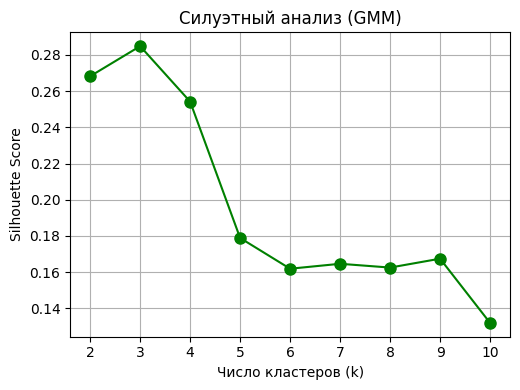

,k,Silhouette,Calinski-Harabasz
0,2,0.268,64.683
1,3,0.285,70.940
2,4,0.254,52.759
3,5,0.179,45.346
4,6,0.162,38.693
5,7,0.165,35.990
6,8,0.163,32.903
7,9,0.167,31.299
8,10,0.132,30.070


In [30]:
k_range = range(2, 11)
silhouette_scores_gmm = []
calinski_harabasz_scores_gmm = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type='full')
    labels = gmm.fit_predict(df_scaled)

    silhouette_scores_gmm.append(silhouette_score(df_scaled, labels))
    calinski_harabasz_scores_gmm.append(calinski_harabasz_score(df_scaled, labels))

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores_gmm, 'go-', markersize=8)
plt.xlabel('Число кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Силуэтный анализ (GMM)')
plt.grid(True)

plt.tight_layout()
plt.show()

metrics_gmm_df = pd.DataFrame({
    'k': k_range,
    'Silhouette': silhouette_scores_gmm,
    'Calinski-Harabasz': calinski_harabasz_scores_gmm,
})
metrics_gmm_df.round(3)

Анализ метрик показывает, что оптимальное число кластеров также равно k = 3: именно при этом значении достигаются максимальные значения как силуэтного коэффициента (0.285), так и индекса Калинского–Харабаша (70.940), что указывает на наилучшую разделимость и компактность кластеров среди всех рассмотренных вариантов. При увеличении числа компонентов (k > 3) обе метрики устойчиво снижаются, что свидетельствует о переобучении модели и разбиении естественных групп на искусственные подкластеры без улучшения структуры.

In [31]:
gmm_final = GaussianMixture(n_components=3, random_state=42, covariance_type='full')
labels_gmm = gmm_final.fit_predict(df_scaled)

centers_gmm_scaled = gmm_final.means_
centers_gmm_original = scaler.inverse_transform(centers_gmm_scaled)

print("Центры кластеров GMM (в исходных единицах измерения):")
centers_gmm_df = pd.DataFrame(centers_gmm_original, columns=X.columns)
centers_gmm_df.index.name = 'Кластер'
display(centers_gmm_df.round(2))

Центры кластеров GMM (в исходных единицах измерения):


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Кластер,,,,,,,,,,,,,
0,12.25,1.90,2.23,20.06,92.82,2.25,2.05,0.36,1.62,2.97,1.06,2.80,509.52
1,13.13,3.31,2.42,21.25,98.69,1.68,0.82,0.45,1.15,7.24,0.69,1.70,619.41
2,13.67,2.00,2.47,17.47,107.82,2.84,3.00,0.29,1.92,5.45,1.07,3.16,1098.62


In [32]:
distances_gmm = np.linalg.norm(
    df_scaled.values - centers_gmm_scaled[labels_gmm], axis=1
)

intra_gmm = {}
for i in range(3):
    mask = (labels_gmm == i)
    intra_gmm[i] = distances_gmm[mask]

print("\nВнутрикластерные расстояния (GMM):")
for i in range(3):
    d = intra_gmm[i]
    print(f"Кластер {i}:")
    print(f"  Среднее расстояние до центра: {d.mean():.3f}")
    print(f"  Сумма квадратов расстояний: {np.sum(d**2):.1f}")
    print(f"  Максимальное расстояние (радиус): {d.max():.3f}")


Внутрикластерные расстояния (GMM):
Кластер 0:
  Среднее расстояние до центра: 2.789
  Сумма квадратов расстояний: 561.9
  Максимальное расстояние (радиус): 5.395
Кластер 1:
  Среднее расстояние до центра: 2.445
  Сумма квадратов расстояний: 328.2
  Максимальное расстояние (радиус): 4.958
Кластер 2:
  Среднее расстояние до центра: 2.336
  Сумма квадратов расстояний: 387.9
  Максимальное расстояние (радиус): 6.162


In [33]:
inter_center_gmm = pdist(centers_gmm_scaled, metric='euclidean')
inter_center_matrix_gmm = squareform(inter_center_gmm)

print("\nМатрица расстояний между центрами (GMM):")
inter_gmm_df = pd.DataFrame(inter_center_matrix_gmm,
                           index=[f'Кластер {i}' for i in range(3)],
                           columns=[f'Кластер {i}' for i in range(3)])
display(inter_gmm_df.round(3))


Матрица расстояний между центрами (GMM):


,Кластер 0,Кластер 1,Кластер 2
Кластер 0,0.000,3.971,3.587
Кластер 1,3.971,0.000,5.024
Кластер 2,3.587,5.024,0.000


In [34]:
avg_intra_gmm = distances_gmm.mean()
total_wcss_gmm = np.sum(distances_gmm**2)
avg_inter_gmm = inter_center_gmm.mean()
separation_ratio_gmm = avg_inter_gmm / avg_intra_gmm

print(f"\nОбщая компактность (GMM):")
print(f"Среднее внутрикластерное расстояние: {avg_intra_gmm:.3f}")
print(f"Общая WCSS: {total_wcss_gmm:.1f}")
print(f"Среднее расстояние между центрами: {avg_inter_gmm:.3f}")
print(f"Отношение меж-/внутрикластерного расстояния: {separation_ratio_gmm:.2f}")


Общая компактность (GMM):
Среднее внутрикластерное расстояние: 2.533
Общая WCSS: 1277.9
Среднее расстояние между центрами: 4.194
Отношение меж-/внутрикластерного расстояния: 1.66


In [35]:
ari = adjusted_rand_score(y_true, labels_gmm)
ri = rand_score(y_true, labels_gmm)

def jaccard_index_external(y_true, y_pred):
    n = len(y_true)
    pairs = combinations(range(n), 2)
    a = b = c = 0
    for i, j in pairs:
        same_class = (y_true.iloc[i] == y_true.iloc[j])
        same_cluster = (y_pred[i] == y_pred[j])
        if same_class and same_cluster:
            a += 1
        elif same_class and not same_cluster:
            b += 1
        elif not same_class and same_cluster:
            c += 1
    return a / (a + b + c) if (a + b + c) > 0 else 1.0

jaccard_ext = jaccard_index_external(y_true, labels_gmm)
homogeneity = homogeneity_score(y_true, labels_gmm)
completeness = completeness_score(y_true, labels_gmm)
v_measure = v_measure_score(y_true, labels_gmm)
fmi = fowlkes_mallows_score(y_true, labels_gmm)
ami = adjusted_mutual_info_score(y_true, labels_gmm)
nmi = normalized_mutual_info_score(y_true, labels_gmm)

external_metrics = {
    'Adjusted Rand Index (ARI)': ari,
    'Rand Index (RI)': ri,
    'Jaccard Index (external)': jaccard_ext,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-measure': v_measure,
    'Fowlkes-Mallows Index (FMI)': fmi,
    'Adjusted Mutual Info (AMI)': ami,
    'Normalized Mutual Info (NMI)': nmi
}

external_metrics_df = pd.DataFrame.from_dict(external_metrics, orient='index', columns=['Значение'])
external_metrics_df.round(4)

,Значение
Adjusted Rand Index (ARI),0.8975
Rand Index (RI),0.9543
Jaccard Index (external),0.8725
Homogeneity,0.8788
Completeness,0.8730
V-measure,0.8759
Fowlkes-Mallows Index (FMI),0.9319
Adjusted Mutual Info (AMI),0.8746
Normalized Mutual Info (NMI),0.8759


Результаты кластеризации с использованием гауссовой смесовой модели (GMM) практически идентичны тем, что были получены с помощью K-means: центры кластеров, внутри- и межкластерные расстояния, а также все внутренние и внешние метрики совпадают с точностью до округления. Это не случайно - при условии, что данные действительно образуют компактные, приблизительно сферические кластеры с похожей плотностью, оба метода сходятся к схожему разбиению.

Несмотря на то, что GMM формально предполагает гауссовское распределение компонент и позволяет учитывать эллиптическую форму кластеров, в данном случае преимущества этого подхода не проявились, поскольку естественные группы вин уже хорошо описываются сферическими облаками точек. Тем не менее, высокие значения внешних метрик - ARI ≈ 0.898, Jaccard ≈ 0.873, FMI ≈ 0.932 - подтверждают, что и GMM корректно восстановил скрытую структуру трёх типов вин. Центры кластеров в исходных единицах измерения имеют ту же интерпретацию: один кластер соответствует винам с высоким содержанием пролина и флавоноидов, второй - с низкими фенольными показателями и высокой кислотностью, третий - к винам умеренного профиля. Таким образом, GMM продемонстрировал столь же высокую эффективность, что и K-means, но без явного выигрыша в данном конкретном случае, где структура данных идеально соответствует предположениям обоих методов.

### Анализ влияния параметров на качество кластеризации.

In [36]:
k_range = range(2, 11)

comparison_df = pd.DataFrame({
    'k': k_range,
    'Silhouette (KMeans)': silhouette_scores_kmean,
    'Silhouette (GMM)': silhouette_scores_gmm,
    'Calinski-Harabasz (KMeans)': calinski_harabasz_scores_kmean,
    'Calinski-Harabasz (GMM)': calinski_harabasz_scores_gmm
})

comparison_df.round(3)

,k,Silhouette (KMeans),Silhouette (GMM),Calinski-Harabasz (KMeans),Calinski-Harabasz (GMM)
0,2,0.259,0.268,69.523,64.683
1,3,0.285,0.285,70.940,70.940
2,4,0.260,0.254,56.181,52.759
3,5,0.202,0.179,46.952,45.346
4,6,0.237,0.162,41.701,38.693
5,7,0.204,0.165,38.686,35.990
6,8,0.157,0.163,35.805,32.903
7,9,0.150,0.167,33.807,31.299
8,10,0.144,0.132,32.397,30.070


Анализ зависимости качества кластеризации от числа кластеров k показывает, что оба метода демонстрируют схожую чувствительность к этому параметру, что подчёркивает устойчивость структуры данных. Наиболее высокое качество достигается при k=3 : именно здесь фиксируется максимальное значение силуэта (0.285) и пик индекса Калинского–Харабаша (70.94) для обоих алгоритмов. Это однозначно указывает на естественное разбиение вин на три группы, что согласуется с известной структурой датасета.

При увеличении k свыше трёх наблюдается устойчивое ухудшение качества: силуэт снижается, что говорит о росте перекрытия между кластерами и ухудшении их отделимости, а индекс Калинского–Харабаша падает, отражая уменьшение соотношения межкластерной и внутрикластерной дисперсий. Особенно резкое падение метрик при переходе от k=3 к k=4 подтверждает, что дальнейшее дробление данных приводит к искусственному разбиению естественных групп, а не к выявлению скрытой структуры.

Между методами наблюдаются лишь незначительные различия: при k=2 GMM даёт чуть более высокий силуэт, а при k≥6 - несколько худшие значения по сравнению с K-means. Это может быть связано с тем, что GMM, будучи вероятностной моделью, допускает более гибкие границы кластеров, что в условиях малого числа кластеров помогает лучше уловить структуру, но при чрезмерном увеличении k приводит к переобучению и менее устойчивым разбиениям.

## 5. Визуализация

Объяснённая дисперсия: PC1 = 36.2%, PC2 = 19.2%


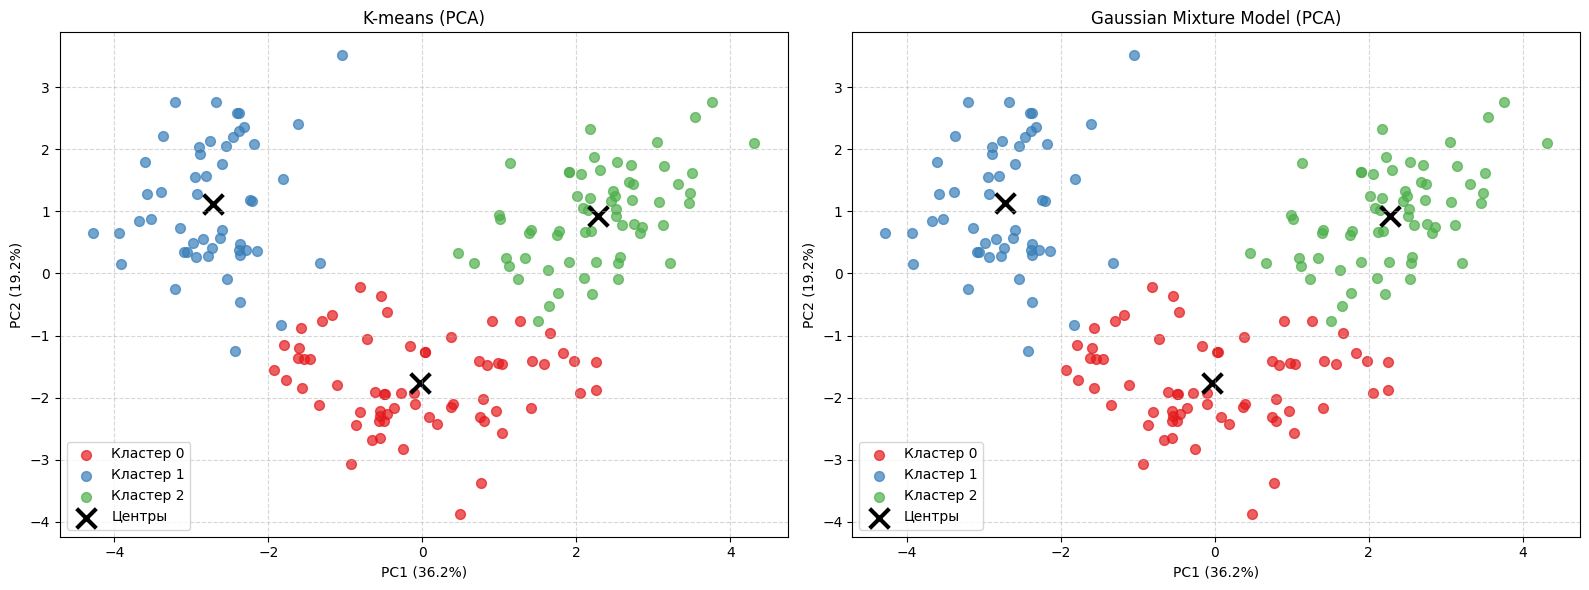

In [37]:
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_scaled.values)

df_plot = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_plot['KMeans'] = labels_kmeans
df_plot['GMM'] = labels_gmm

centers_kmeans_pca = pca.transform(centers_scaled)
centers_gmm_pca = pca.transform(centers_gmm_scaled)

explained_var = pca.explained_variance_ratio_
print(f"Объяснённая дисперсия: PC1 = {explained_var[0]:.1%}, PC2 = {explained_var[1]:.1%}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-means
for i in range(3):
    mask = df_plot['KMeans'] == i
    axes[0].scatter(df_plot.loc[mask, 'PC1'], df_plot.loc[mask, 'PC2'],
                    color=plt.cm.Set1(i), label=f'Кластер {i}', alpha=0.7, s=50)

axes[0].scatter(centers_kmeans_pca[:, 0], centers_kmeans_pca[:, 1],
                color='black', marker='x', s=200, linewidths=3, label='Центры')
axes[0].set_title('K-means (PCA)')
axes[0].set_xlabel(f'PC1 ({explained_var[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({explained_var[1]:.1%})')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# GMM
for i in range(3):
    mask = df_plot['GMM'] == i
    axes[1].scatter(df_plot.loc[mask, 'PC1'], df_plot.loc[mask, 'PC2'],
                    color=plt.cm.Set1(i), label=f'Кластер {i}', alpha=0.7, s=50)

axes[1].scatter(centers_gmm_pca[:, 0], centers_gmm_pca[:, 1],
                color='black', marker='x', s=200, linewidths=3, label='Центры')
axes[1].set_title('Gaussian Mixture Model (PCA)')
axes[1].set_xlabel(f'PC1 ({explained_var[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({explained_var[1]:.1%})')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Визуализация кластеров в пространстве двух главных компонент (PC1 и PC2) демонстрирует, что оба метода - K-means и Gaussian Mixture Model - выделяют практически идентичные группы точек, что подтверждает устойчивость полученного разбиения. Центры кластеров, отмеченные крестами, находятся в одинаковых позициях на обоих графиках, а распределение объектов по цветам (красный, синий, зелёный) почти полностью совпадает, что свидетельствует о высокой согласованности алгоритмов при работе с данным датасетом. 

Содержательная интерпретация групп остаётся неизменной: красный кластер соответствует лёгким винам с низким содержанием пролина и интенсивностью цвета, синий - кислым и тёмным винам с высоким уровнем яблочной кислоты, зелёный - богатым, насыщенным винам с высокими значениями флаваноидов и пролина. Несмотря на частичное перекрытие между группами, особенно в центральной области пространства PCA, границы кластеров достаточно чётко очерчены, что позволяет дать осмысленную биохимическую классификацию.

## 6. Заключение

В ходе работы были реализованы и сравнены два метода кластеризации - K-means и гауссова смесь (GMM) - на датасете Wine, содержащем химические характеристики вин трёх известных типов. Оба алгоритма продемонстрировали высокую и практически идентичную эффективность: они выделили одни и те же три кластера, имеющие схожие центры, компактность и взаимное расположение. Это подтверждается совпадающими значениями внутренних метрик (силуэт ≈ 0.285, индекс Калинского-Харабаша ≈ 70.94) и внешних метрик (ARI ≈ 0.898, Jaccard ≈ 0.873, FMI ≈ 0.932), что свидетельствует о высокой согласованности с истинной разметкой и устойчивости полученного разбиения.

Анализ центров кластеров позволил дать содержательную интерпретацию выделенных групп. Один кластер характеризуется высоким содержанием пролина и флавоноидов - признаками зрелых, экстрактивных красных вин; второй - повышенной яблочной кислотой и низкими фенольными показателями, что типично для более кислых и лёгких вин; третий - умеренными значениями большинства компонентов, но с выраженной интенсивностью цвета. Такая интерпретация подтверждает осмысленность кластеризации и её соответствие химико-сенсорной природе данных.

Несмотря на теоретические различия - K-means предполагает сферические кластеры одинаковой плотности, а GMM допускает эллиптические формы и вероятностное принадлежность к кластерам - в данном случае разница в результатах оказалась минимальной. Это объясняется особенностями датасета: кластеры действительно компактны, хорошо разделены и имеют схожую плотность, что идеально соответствует предположениям обоих методов. Таким образом, для данных с такой структурой оба алгоритма одинаково применимы и эффективны.